In [20]:
import zipfile
import os

# Correct file path
zip_path = "/content/Resized_Images (1).zip"

# Extract to a new folder
extract_path = "/content/dental_bounding"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extraction complete! Files are in: {extract_path}")


Extraction complete! Files are in: /content/dental_bounding


In [21]:



import os
import cv2
import pandas as pd

# Define the classes we are interested in:
target_classes = ['Cavity', 'Impacted Tooth', 'Infection', 'Fractured teeth']

# Define dataset directories (adjust paths as needed)
dataset_dirs = [
    "/content/dental_bounding/test",
    "/content/dental_bounding/train",
    "/content/dental_bounding/valid"
]

# Define an output root directory for annotated images in Colab
output_root = '/content/bbox_annotated'
if not os.path.exists(output_root):
    os.makedirs(output_root)

# (Optional) Define colors for each target class (BGR format for OpenCV)
colors = {
    'Cavity': (255, 255, 0),        # Cyan
    'Impacted Tooth': (0, 0, 255),  # Red
    'Infection': (0, 255, 255),     # Yellow
    'Fractured teeth': (255, 165, 0)#orange
}

# Process each dataset folder
for dset in dataset_dirs:
    # Use the base name (e.g., "train") for output folder naming
    dset_basename = os.path.basename(dset)
    print(f"Processing dataset: {dset_basename}")

    # Adjust the CSV file name based on the folder
    if dset_basename == "train":
        annotation_path = os.path.join(dset, 'train_data.csv')
    elif dset_basename == "test":
        annotation_path = os.path.join(dset, 'test_data.csv')
    elif dset_basename == "valid":
        annotation_path = os.path.join(dset, 'val_data.csv')
    else:
        print(f"Unknown dataset: {dset_basename}")
        continue

    # Read the CSV file containing the annotations
    df = pd.read_csv(annotation_path)

    # Create output directory for the annotated images for this dataset
    output_dset_folder = os.path.join(output_root, dset_basename)
    if not os.path.exists(output_dset_folder):
        os.makedirs(output_dset_folder)

    # Get the unique filenames from the annotations CSV
    unique_filenames = df['filename'].unique()

    for filename in unique_filenames:
        image_path = os.path.join(dset, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: could not read image {image_path}")
            continue

        # Get all annotation rows for the current image
        annots = df[df['filename'] == filename]

        # Loop over each annotation (bounding box) in this image
        for idx, row in annots.iterrows():
            # Convert coordinates to integers
            xmin, ymin = int(row['xmin']), int(row['ymin'])
            xmax, ymax = int(row['xmax']), int(row['ymax'])
            label = row['class_name']  # Change from 'class' to 'class_name'

            # Check that the label is in our target classes
            if label not in target_classes:
                continue

            # Validate bounding box coordinates (optional checks)
            img_height, img_width = image.shape[:2]
            if xmin < 0 or ymin < 0 or xmax > img_width or ymax > img_height:
                print(f"Skipping {filename}: bbox out of image bounds")
                continue
            if xmin >= xmax or ymin >= ymax:
                print(f"Skipping {filename}: invalid bbox coordinates")
                continue
            if (xmax - xmin) < 5 or (ymax - ymin) < 5:
                print(f"Skipping {filename}: bbox too small")
                continue

            # Draw the bounding box
            box_color = colors.get(label, (0, 255, 255))  # Default color if label not found
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), box_color, 2)
            # Optionally, add the label text above the box
            cv2.putText(image, label, (xmin, max(ymin - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, box_color, 2)

        # Save the annotated image to the output folder (use the original filename)
        save_path = os.path.join(output_dset_folder, filename)
        cv2.imwrite(save_path, image)

print("Bounding box annotation completed!")


Processing dataset: test
Processing dataset: train
Processing dataset: valid
Bounding box annotation completed!


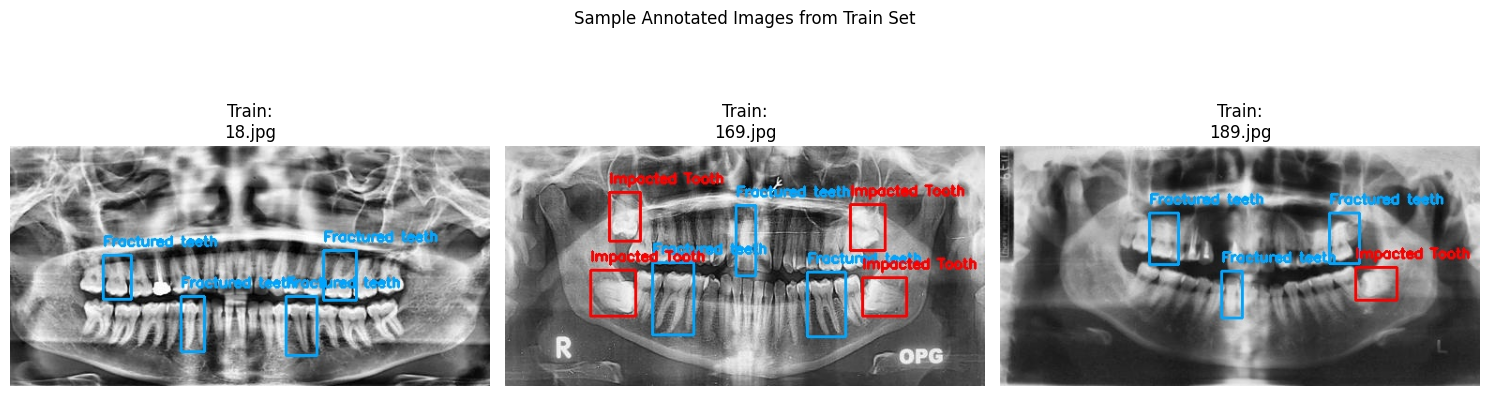

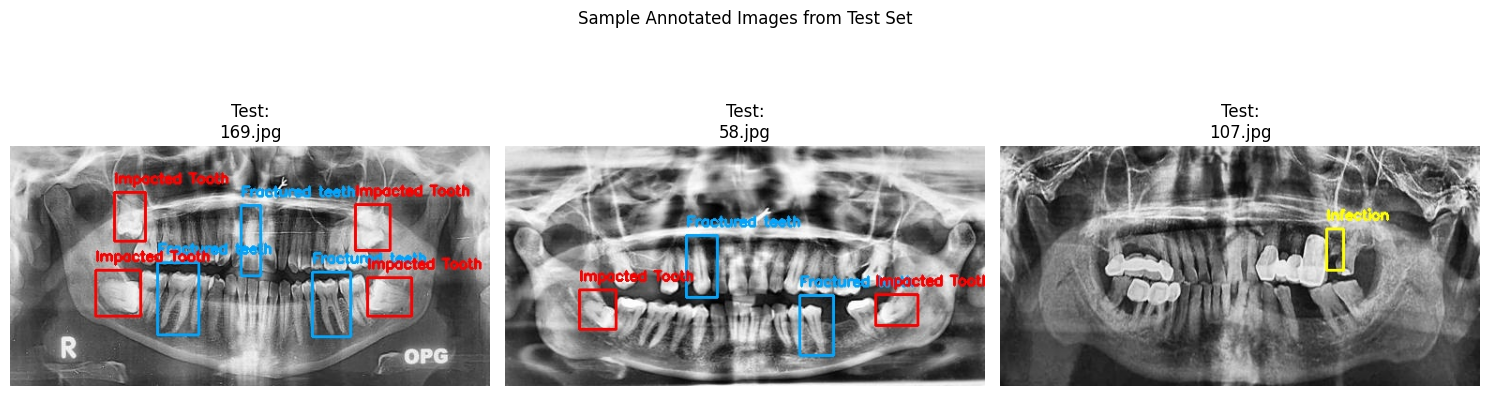

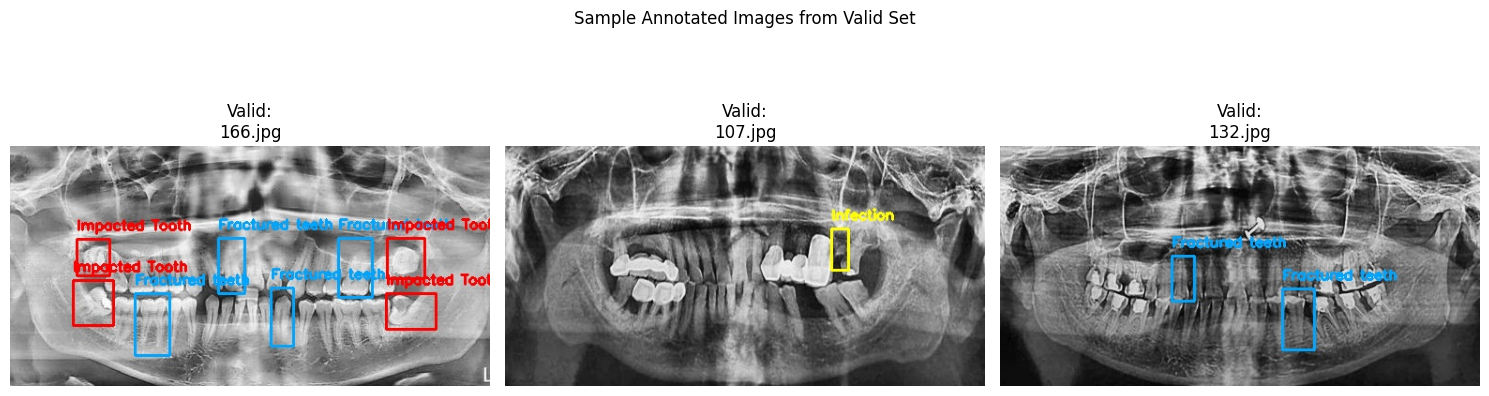

In [22]:
# --- Visualization ---
import matplotlib.pyplot as plt
import cv2
import os

# Define the output folder where annotated images are stored.
output_root = '/content/bbox_annotated'  # Updated for Colab

# List of dataset splits to visualize
dataset_splits = ['train', 'test', 'valid']

# Loop through each dataset folder and visualize a few images (e.g., 3 images per dataset)
for ds in dataset_splits:
    ds_folder = os.path.join(output_root, ds)
    if not os.path.exists(ds_folder):
        print(f"Folder not found: {ds_folder}")
        continue

    image_files = os.listdir(ds_folder)
    if len(image_files) == 0:
        print(f"No images found in {ds_folder}")
        continue

    # Select a few sample images (e.g., first 3)
    sample_files = image_files[:3]

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(sample_files):
        img_path = os.path.join(ds_folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        # Convert image from BGR (OpenCV default) to RGB for plotting
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(sample_files), i + 1)
        plt.imshow(img_rgb)
        plt.title(f"{ds.capitalize()}:\n{img_file}")
        plt.axis("off")
    plt.suptitle(f"Sample Annotated Images from {ds.capitalize()} Set")
    plt.tight_layout()
    plt.show()


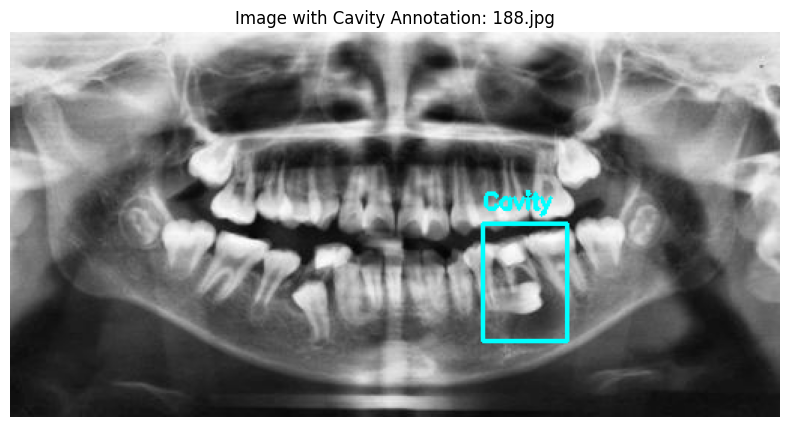

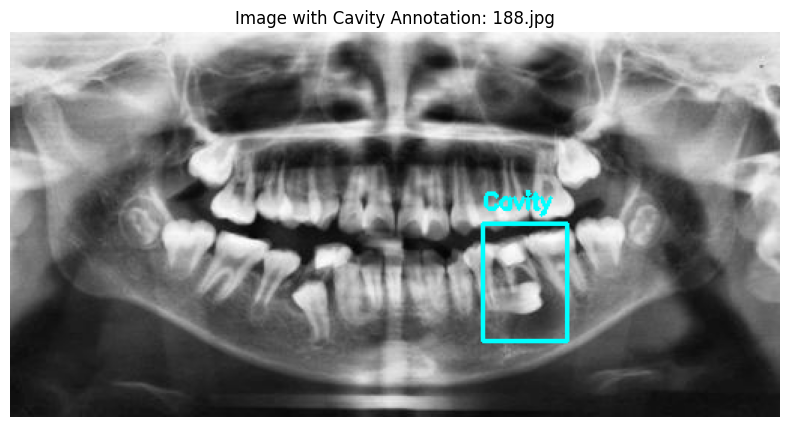

CSV file not found: /content/dental_bounding/valid/valid_data.csv


In [23]:
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

# Define the root directory where your dataset is stored.
dataset_root = '/content/dental_bounding'  # Update this path if needed

# Dataset split
dataset_splits = ['train', 'test', 'valid']

# Loop through each dataset folder and visualize images with "Cavity" class
for ds in dataset_splits:
    ds_folder = os.path.join(dataset_root, ds)
    if not os.path.exists(ds_folder):
        print(f"Folder not found: {ds_folder}")
        continue

    # Find the corresponding CSV file for annotations (inside each folder)
    csv_file = os.path.join(ds_folder, f'{ds}_data.csv')
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        continue

    df = pd.read_csv(csv_file)

    # Filter the annotations for the "Cavity" class
    cavity_annotations = df[df['class_name'] == 'Cavity']

    if cavity_annotations.empty:
        print(f"No 'Cavity' annotations found in {ds_folder}")
        continue

    # Display a sample image with "Cavity" annotations
    for _, row in cavity_annotations.iterrows():
        filename = row['filename']
        img_path = os.path.join(ds_folder, filename)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # Draw the bounding boxes for the "Cavity" class
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)  # Cyan color for "Cavity"
        cv2.putText(img, 'Cavity', (xmin, max(ymin - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        # Convert image from BGR (OpenCV default) to RGB for matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.figure(figsize=(10, 5))
        plt.imshow(img_rgb)
        plt.title(f"Image with Cavity Annotation: {filename}")
        plt.axis('off')
        plt.show()
        break  # Show only the first image with "Cavity" annotation


Found in TRAIN set: 110.jpg with classes: {'Infection', 'Impacted Tooth', 'Fractured teeth'}


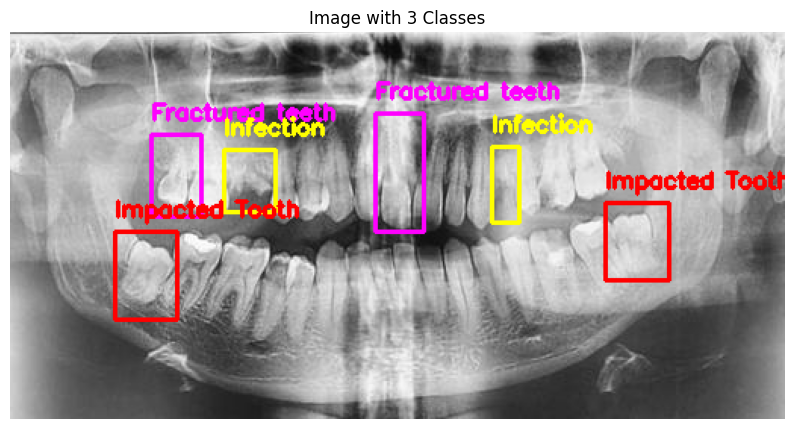

In [24]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Define the dataset root and splits
dataset_root = '/content/dental_bounding'
dataset_splits = ['train', 'test', 'valid']

# Define target classes
target_classes = ['Cavity', 'Impacted Tooth', 'Infection', 'Fractured teeth']

# Colors for different classes (in BGR)
colors = {
    'Cavity': (255, 255, 0),           # Cyan
    'Impacted Tooth': (0, 0, 255),     # Red
    'Infection': (0, 255, 255),        # Yellow
    'Fractured teeth': (255, 0, 255)   # Magenta
}

# Function to show image with bounding boxes
def display_image_with_boxes(image_path, annots):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    for _, row in annots.iterrows():
        xmin, ymin = int(row['xmin']), int(row['ymin'])
        xmax, ymax = int(row['xmax']), int(row['ymax'])
        label = row['class_name']
        color = colors.get(label, (255, 255, 255))
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(image, label, (xmin, max(ymin - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Convert to RGB and show
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title(f"Image with {len(set(annots['class_name']))} Classes")
    plt.axis('off')
    plt.show()

# Search for image with at least 3 classes
found = False
for ds in dataset_splits:
    ds_folder = os.path.join(dataset_root, ds)
    csv_path = os.path.join(ds_folder, f'{ds}_data.csv')
    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(csv_path)
    grouped = df.groupby('filename')

    for filename, group in grouped:
        unique_classes = set(group['class_name'])
        intersection = unique_classes.intersection(target_classes)

        if len(intersection) >= 3:
            print(f"Found in {ds.upper()} set: {filename} with classes: {intersection}")
            img_path = os.path.join(ds_folder, filename)
            display_image_with_boxes(img_path, group)
            found = True
            break

    if found:
        break

if not found:
    print("No image found with at least 3 different target classes.")


✅ Found: 188.jpg in TRAIN with classes: {'Cavity', 'Impacted Tooth', 'Fractured teeth'}


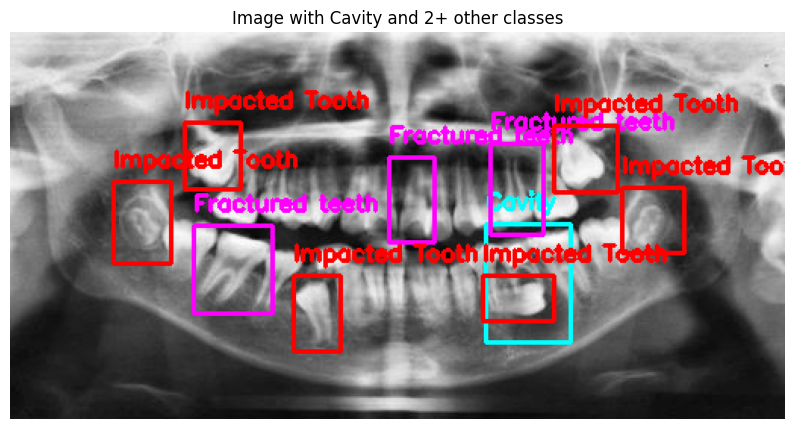

In [25]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Define dataset structure
dataset_root = '/content/dental_bounding'
dataset_splits = ['train', 'test', 'valid']

# Define target classes
target_classes = ['Cavity', 'Impacted Tooth', 'Infection', 'Fractured teeth']

# Class-specific colors for visualization
colors = {
    'Cavity': (255, 255, 0),           # Cyan
    'Impacted Tooth': (0, 0, 255),     # Red
    'Infection': (0, 255, 255),        # Yellow
    'Fractured teeth': (255, 0, 255)   # Magenta
}

# Function to display image with bounding boxes
def display_image_with_boxes(image_path, annots):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    for _, row in annots.iterrows():
        xmin, ymin = int(row['xmin']), int(row['ymin'])
        xmax, ymax = int(row['xmax']), int(row['ymax'])
        label = row['class_name']
        color = colors.get(label, (255, 255, 255))  # Default to white if not found
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(image, label, (xmin, max(ymin - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Convert to RGB and show with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title(f"Image with Cavity and 2+ other classes")
    plt.axis('off')
    plt.show()

# Find image with 'Cavity' and 2+ additional classes
found = False
for ds in dataset_splits:
    folder = os.path.join(dataset_root, ds)
    csv_path = os.path.join(folder, f'{ds}_data.csv')

    if not os.path.exists(csv_path):
        print(f"CSV not found: {csv_path}")
        continue

    df = pd.read_csv(csv_path)
    grouped = df.groupby('filename')

    for filename, group in grouped:
        classes_in_image = set(group['class_name'])

        # Check if 'Cavity' is present
        if 'Cavity' in classes_in_image:
            other_classes = classes_in_image.intersection(set(target_classes) - {'Cavity'})
            if len(other_classes) >= 2:
                print(f"✅ Found: {filename} in {ds.upper()} with classes: {classes_in_image}")
                img_path = os.path.join(folder, filename)
                display_image_with_boxes(img_path, group)
                found = True
                break

    if found:
        break

if not found:
    print("❌ No image found with Cavity and at least two other classes.")
